In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [3]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()


In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [5]:
df = pd.read_csv("/kaggle/input/bengali-pharmaceutical-reviews/LargePharmaVal.csv")

In [6]:
df

,Reviews,category,Label,Length,Word Count
0,চকলেট নিয়ে খুব হতাশ। এক্সপায়ার ডেট শেষ আর অত...,Random/Misc,1,66,11
1,পঁচিশটা অর্ডার করেছিলাম পেয়েছি পঞ্চাশটা সাথে ...,medical_kits,4,183,32
2,সুন্দর প্যাকেজিং করে দিয়েছে! ১০০% অরিজিনাল প্...,womens_item,5,110,15
3,আমি কেন অনলাইনে প্রডাক্ট ক্রয় করলাম ভাই? গ্লোব...,medicines,2,107,18
4,ডেলিভারি একটু দেরি হলেও মাল ভালো। শ্যাম্পু প্র...,womens_item,4,92,15
...,...,...,...,...,...
9510,একদম নিম্ন মানের নেবুলাইজার দিয়ে ঠকালেন। মার্...,medical_kits,1,64,11
9511,"প্রথম কথা, এটা আইসক্রিম ফ্লেভার না, মেনথল/মিন্...",adult_items,1,375,61
9512,😭😭 কি মারাত্মক মাস্ক! মানসম্মত না আর সাইজ ছোট ...,medical_kits,1,53,10
9513,যা ছিল আমার ইচ্ছায় মোটামুটি সব দিয়েছেন সেলার। ...,medicines,4,135,22


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Reviews     9515 non-null   object
 1   category    9515 non-null   object
 2   Label       9515 non-null   int64 
 3   Length      9515 non-null   int64 
 4   Word Count  9515 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 371.8+ KB


In [8]:
df.Label.value_counts()

Label
5    2238
1    2199
4    1989
2    1563
3    1526
Name: count, dtype: int64

In [9]:
df['Label'] = df['Label'].map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})
print(df['Label'].value_counts()) 

Label
4    2238
0    2199
3    1989
1    1563
2    1526
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into train and temp (test + validation) sets
train_data, temp_data = train_test_split(df, test_size=0.3, stratify=df['Label'], random_state=1)

# Step 2: Split the temp set into validation and test sets (10% validation, 20% test)
val_data, test_data = train_test_split(temp_data, test_size=2/3, stratify=temp_data['Label'], random_state=1)

In [11]:
train_data.to_csv("/kaggle/working/train_data.csv", index=False)
val_data.to_csv("/kaggle/working/val_data.csv", index=False)
test_data.to_csv("/kaggle/working/test_data.csv", index=False)

In [12]:
train_data.shape, val_data.shape

((6660, 5), (951, 5))

In [13]:
with pd.option_context('display.max_colwidth',0):
    display(train_data.sample(n=10))

,Reviews,category,Label,Length,Word Count
4669,ওয়াটার ব্যাগ দিয়েছে ভালো কিন্তু চার্জার দেয় নাই সেলার।,medical_kits,2,54,9
5746,"মেয়াদ যথেষ্ট আছে, ডেলিভারি চার্জ একটু বেশি। শ্যাম্পু নিয়ে কয়েকদিন ব্যবহার করে তারপর আপডেট দিব",womens_item,3,96,15
4239,এখন পর্যন্ত মোটামুটি সব ঠিকই আছে। 3দিনের মধ্যে হাতে পেয়েছি প্রোডাক্টি। ধন্যবাদ সেলার কে দ্রুত শিপিং করায়\nঅনেক ভাল একটি প্রোডাক্ট । আমার কাছে খুব ভাল লেগেছে । এত কম দামে ভাল প্রোডাক্ট পাব ভাবিনি ।,body_fitness,4,195,36
3074,"ডায়াপার নিয়ে তেমন খুশি না। কোয়ালিটি তেমন একটা ভালো না, পিকআপ পয়েন্ট অনেক দূরে",baby_items,1,81,14
5006,"কোয়ালিটি মানসম্মত, ডেলিভারি ম্যান ভদ্র ছিল। ওষুধ নিয়ে ব্যবহার করে দেখতে হবে কেমন কাজ করে",medicines,3,90,15
5546,এন্টিসেপটিক এর বোতল খোলা পেয়েছি। এগুলো তো ঠিক না। ডেলিভারি ম্যানের কাজ এটা সম্ভবত।,Random/Misc,1,82,14
2715,সেলারের মনে তেমন কোনো চিন্তা দেখছি না। ডিসকাউন্ট দেয়ার কোনো খবর নাই।,medical_kits,1,69,12
5569,মাশাআল্লাহ প্রোডাক্টটা অল্প সময়ের মধ্যে আসছে প্রডাক্ট টা অনেক ভালো আপনারা চাইলে নিতে পারেন আলহামদুলিল্লাহ। \nসেলার এর ব্যবহার অনেক চমৎকার তা মেসেজের রিপ্লাই দেখেই বুঝছিলাম। ডেলিভারি ম্যান আমাকে একদম বাড়ায় পৌঁছে দিয়েগেছে।,medical_kits,4,222,32
3889,"🤬🤬 নকল মাল নেবুলাইজার। অর্ডার করেছিলাম 3টা, পেলাম 2টা 🤬🤬",medical_kits,0,56,10
3052,মাস্কের ভিতর থেকে একটা বাজে গন্ধ আছে মনে হচ্ছে। মুখে দেয়া জিনিসের থেকে এমন গন্ধ আসলে কি মানা যায়। সংশ্লিষ্ট সকলকে বিষয়টা দেখার অনুরোধ রইল।,medical_kits,1,138,25


In [14]:
with pd.option_context('display.max_colwidth',0):
    display(val_data.sample(n=10))

,Reviews,category,Label,Length,Word Count
1651,অত্যাধুনিক মানের খুবই ভালো মানের বেল্ট তৈরী করেছেন আপনারা মাশাল্লাহ। কিন্তু বুঝতে পারছি না যে মাথা দিয়ে পড়বো না পায়ের দিক দিয়ে পড়বো। \nব্যবহার বিধি দেয়া জরুরি ছিল আমার মতে।,body_fitness,3,171,30
9214,"৩ টা দেওয়ার কথা থাকলেও প্যাকেটে ২ টা পেয়েছি। হারামজাদা বাটপার সেলার। তোর জন্মের ঠিক নাই। শালা বজ্জাত, প্রতারক।",adult_items,0,113,19
4813,"আলহামদুলিল্লাহ খুব ভালো একটা জিনিস 🥰! ১০০% কার্যকরী। সুন্দর প্যাকেজিং করে দিয়েছে নিশ্চিন্তে কিনতে পারেন, প্রতারণার ভয় নাই 😍",medical_kits,4,125,19
6017,সাপ্লিমেন্ট আলহামদুলিল্লাহ ঠিকঠাক পেয়েছি। ব্যবহার করে দেখতে হবে কেমন কাজ করে নিশ্চিন্তে কিনতে পারেন,body_fitness,3,100,14
7133,"মাস্ক কোয়ালিটি মানসম্মত। দাম একটু কমানো দরকার, মোটামুটি ভরসা করা যায়",medical_kits,3,70,11
6595,খুব উন্নত মানের প্রোডাক্ট! খুবই প্রিমিয়াম প্রোডাক্ট 😍 💯 ১০% ডিসকাউন্ট পেয়েছি। আমি সবাইকে সুপারিশ করবো,medical_kits,4,103,16
2865,খুবই প্রিমিয়াম প্রোডাক্ট 😍। খুব উন্নত মানের প্রোডাক্ট। অফলাইনের চেয়ে অনেক সস্তা ধন্যবাদ সেলার ভাই ❤️ 🤗,medical_kits,4,104,17
6979,১০০% কার্যকরী! ১০০% অরিজিনাল প্রোডাক্ট 💯 দাম অনেক কম পেয়েছি। আমি সবাইকে সুপারিশ করবো,medical_kits,4,85,14
9320,মাশাআল্লাহ চমৎকার একটি প্রোডাক্ট! সুন্দর প্যাকেজিং করে দিয়েছে। সেলারের মত এত ভালো মানুষ কমই দেখেছি সবাই নিঃসন্দেহে কিনতে পারেন 💯 ❤️,medical_kits,4,132,21
1453,"ওয়াটার ব্যাগ প্রোডাক্ট মোটামুটি ভালো। দাম হিসেবে ভালো, নিশ্চিন্তে কিনতে পারেন",medical_kits,3,78,11


In [15]:
# checkpoint = "csebuetnlp/banglabert" "sagorsarker/bangla-bert-base" "csebuetnlp/banglabert_large"
class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 32
    MODEL_PATH = "csebuetnlp/banglabert"
    LR = 2e-5
    DROPOUT = 0.3
    NUM_CLASSES = 5
    SEED = 42
    MAX_LEN = 100
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [16]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

<Axes: ylabel='Count'>

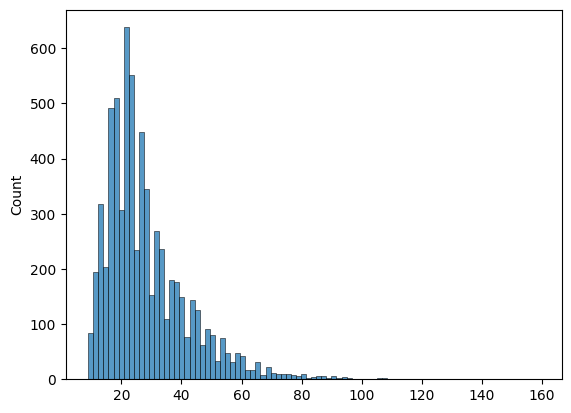

In [17]:
token_counts = []

for _, row in train_data.iterrows():
    text = str(row["Reviews"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

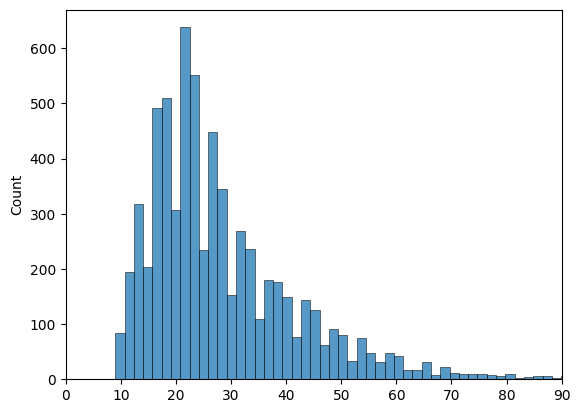

In [18]:
sns.histplot(token_counts)
plt.xlim([0, 90]);

<Axes: ylabel='Count'>

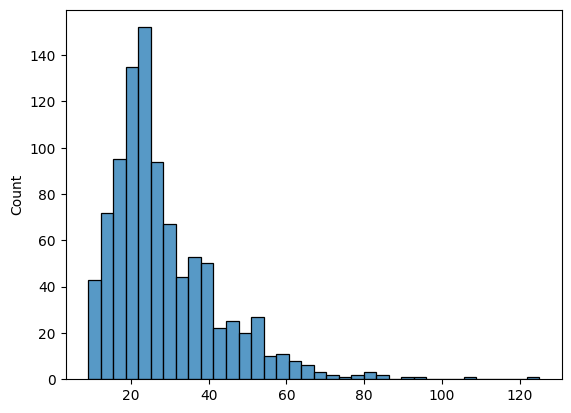

In [19]:
token_counts = []

for _, row in val_data.iterrows():
    text = str(row["Reviews"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)


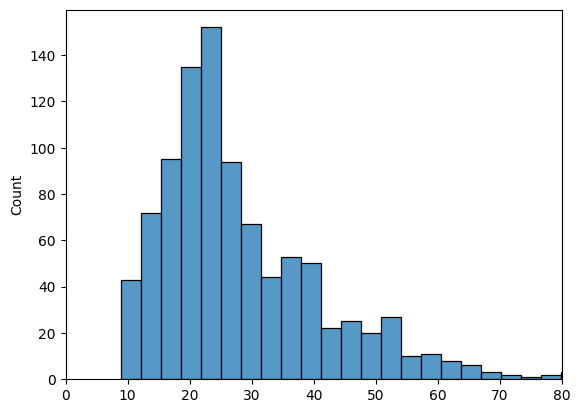

In [20]:
sns.histplot(token_counts)
plt.xlim([0, 80]);

In [21]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.labels = torch.tensor(df.Label.values, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["Reviews"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        labels = self.labels[index]

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='weighted')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)            
            target = data["labels"].to(config.DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(config.DEVICE)  
                attention_mask = data["attention_mask"].to(config.DEVICE)              
                target = data["labels"].to(config.DEVICE)  
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [24]:
# import torch
# import torch.nn as nn
# from transformers import AutoModel, AutoConfig

# class ClassifierModel(nn.Module):
#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
#         self.model = AutoModel.from_pretrained(config.MODEL_PATH, config=self.model_config)
        
#         # Multi-head self attention layer
#         self.attention = nn.MultiheadAttention(
#             embed_dim=self.model_config.hidden_size,
#             num_heads=8,
#             dropout=0.1,
#             batch_first=True
#         )
        
#         # Dense layers
#         self.dense1 = nn.Linear(self.model_config.hidden_size * 2, 512)  # *2 for concatenation with attention
#         self.dense2 = nn.Linear(512, 256)
        
#         # Dropout and normalization
#         self.drop1 = nn.Dropout(p=0.3)
#         self.drop2 = nn.Dropout(p=0.45)
#         self.layer_norm = nn.LayerNorm(256)
        
#         # Output layer
#         self.classifier = nn.Linear(256, config.NUM_CLASSES)
        
#         # Activation
#         self.gelu = nn.GELU()
        
#     def forward(self, input_ids, attention_mask):
#         # Get model outputs
#         outputs = self.model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             return_dict=True
#         )
        
#         # Get sequence output and CLS token
#         sequence_output = outputs.last_hidden_state
#         cls_token = sequence_output[:, 0, :]
        
#         # Apply self-attention
#         attn_output, _ = self.attention(
#             sequence_output,
#             sequence_output,
#             sequence_output,
#             key_padding_mask=~attention_mask.bool()
#         )
        
#         # Global average pooling of attention output
#         avg_pool = torch.mean(attn_output, dim=1)
        
#         # Concatenate CLS token and attention output
#         combined = torch.cat([cls_token, avg_pool], dim=1)
        
#         # Dense layers with dropout
#         x = self.drop1(combined)
#         x = self.dense1(x)
#         x = self.gelu(x)
        
#         x = self.drop2(x)
#         x = self.dense2(x)
#         x = self.gelu(x)
        
#         # Layer normalization
#         x = self.layer_norm(x)
        
#         # Classification layer
#         output = self.classifier(x)
#         return output


# class ClassifierModel(nn.Module):
#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
#         self.model = AutoModel.from_pretrained(config.MODEL_PATH, config=self.model_config)
        
#         # Multi-head self attention with adjusted parameters
#         self.attention = nn.MultiheadAttention(
#             embed_dim=self.model_config.hidden_size,
#             num_heads=12,  # Increased number of heads
#             dropout=0.15,  # Reduced dropout
#             batch_first=True
#         )
        
#         # Additional pooling layer
#         self.max_pool = nn.AdaptiveMaxPool1d(1)
        
#         # Dense layers with adjusted dimensions
#         self.dense1 = nn.Linear(self.model_config.hidden_size * 3, 768)  # *3 for triple concatenation
#         self.dense2 = nn.Linear(768, 384)
        
#         # Adjusted dropout rates
#         self.drop1 = nn.Dropout(p=0.25)
#         self.drop2 = nn.Dropout(p=0.35)
#         self.layer_norm1 = nn.LayerNorm(768)
#         self.layer_norm2 = nn.LayerNorm(384)
        
#         self.classifier = nn.Linear(384, config.NUM_CLASSES)
#         self.gelu = nn.GELU()
        
#     def forward(self, input_ids, attention_mask):
#         outputs = self.model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             return_dict=True
#         )
        
#         sequence_output = outputs.last_hidden_state
#         cls_token = sequence_output[:, 0, :]
        
#         # Apply self-attention
#         attn_output, _ = self.attention(
#             sequence_output,
#             sequence_output,
#             sequence_output,
#             key_padding_mask=~attention_mask.bool()
#         )
        
#         # Multiple pooling strategies
#         avg_pool = torch.mean(attn_output, dim=1)
#         max_pool = torch.max(attn_output, dim=1)[0]
        
#         # Combine all representations
#         combined = torch.cat([cls_token, avg_pool, max_pool], dim=1)
        
#         # Enhanced dense layer processing
#         x = self.drop1(combined)
#         x = self.dense1(x)
#         x = self.layer_norm1(x)
#         x = self.gelu(x)
        
#         x = self.drop2(x)
#         x = self.dense2(x)
#         x = self.layer_norm2(x)
#         x = self.gelu(x)
        
#         output = self.classifier(x)
#         return output
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig

class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(config.MODEL_PATH, config=self.model_config)
        
        # Custom attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim=self.model_config.hidden_size,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(self.model_config.hidden_size, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, config.NUM_CLASSES)
        )
        
    def forward(self, input_ids, attention_mask):
        # Get model outputs
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Apply self-attention
        attn_output, _ = self.attention(
            sequence_output,
            sequence_output,
            sequence_output,
            key_padding_mask=~attention_mask.bool()
        )
        
        # Get CLS token output (first token)
        cls_output = attn_output[:, 0, :]  # [batch_size, hidden_size]
        
        # Get final classification
        output = self.classifier(cls_output)
        
        return output

In [25]:
history = defaultdict(list)
def run_training(save_model = False):
    train_dataset = ClassifierDataset(train_data,tokenizer)
    val_dataset = ClassifierDataset(val_data,tokenizer)
    train_loader = DataLoader(train_dataset, batch_size = config.BATCH_SIZE,
                              collate_fn=data_collator, shuffle =True, num_workers=2)    
    val_loader = DataLoader(val_dataset, batch_size = config.BATCH_SIZE,
                            collate_fn=data_collator, shuffle=False, num_workers=2)   
    
    set_random_seed(config.SEED)
    model = ClassifierModel()
    model.to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr= config.LR, weight_decay=0.01)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    warmup_steps = int(0.1 * num_training_steps)
    
    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps= 0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f" Epoch: {epoch + 1} | Training_loss: {round(train_loss,4)} | Val_loss: {round(val_loss,4)} | Val_f1: {round(val_score,4)}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if val_score > best_score:
            best_score = val_score
            early_stopping_counter = 0
            
            if save_model:
                torch.save(model.state_dict(),f"attention_on_bert_model.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return round(best_score,5)

In [26]:
score =run_training(save_model = True)
print(f"Best f1 Score: {score}")

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

  0%|          | 0/3135 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 1 | Training_loss: 0.4725 | Val_loss: 0.2811 | Val_f1: 0.9033


  0%|          | 0/3135 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 2 | Training_loss: 0.1674 | Val_loss: 0.2651 | Val_f1: 0.9219


  0%|          | 0/3135 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 3 | Training_loss: 0.0989 | Val_loss: 0.2422 | Val_f1: 0.9306


  0%|          | 0/3135 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca2df31cdc0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ca2df31cdc0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
          File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()self._shutdown_workers()

    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 4 | Training_loss: 0.0589 | Val_loss: 0.3411 | Val_f1: 0.9118


  0%|          | 0/3135 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 5 | Training_loss: 0.0436 | Val_loss: 0.3242 | Val_f1: 0.921


  0%|          | 0/3135 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca2df31cdc0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca2df31cdc0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 6 | Training_loss: 0.0307 | Val_loss: 0.3184 | Val_f1: 0.9252


  0%|          | 0/3135 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca2df31cdc0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca2df31cdc0>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

 Epoch: 7 | Training_loss: 0.0193 | Val_loss: 0.3548 | Val_f1: 0.924


  0%|          | 0/3135 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 8 | Training_loss: 0.0158 | Val_loss: 0.375 | Val_f1: 0.921


  0%|          | 0/3135 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 9 | Training_loss: 0.0074 | Val_loss: 0.3619 | Val_f1: 0.9241
Best f1 Score: 0.93063


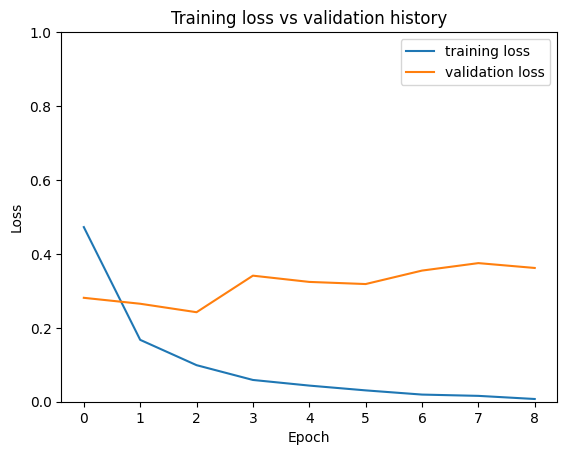

In [27]:
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training loss vs validation history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [28]:
model = ClassifierModel()

In [29]:
model_path = f"/kaggle/working/attention_on_bert_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [30]:
model.to(config.DEVICE)

ClassifierModel(
  (model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [31]:
# test_data = pd.read_csv("hf://datasets/kcrl/Gadet_Review_Dataset/" + splits["test"])

In [32]:
test_data.head()

,Reviews,category,Label,Length,Word Count
3436,কনডম কিনে খুব অনুতপ্ত। নকল মাল 😔😔 দাম আর কোয়া...,adult_items,0,63,13
2492,ওয়াটার ব্যাগ অরিজিনাল মনে হচ্ছে। অন্যরা নিতে ...,medical_kits,3,93,14
4179,বেস কয়েক টা পণ্য সামগ্রিই কিনেছি এর মধ্যে থার্...,medical_kits,1,95,18
1282,চমৎকার একটি প্রোডাক্ট। খুব উন্নত মানের প্রোডাক...,body_fitness,4,93,16
8862,"আমি ঠিক বলতে পারছি না কেন এমন হচ্ছে, মূলত মেডি...",medicines,1,79,15


In [33]:
test_dataset = ClassifierDataset(test_data, tokenizer)

In [34]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    test_dataset, batch_size=64, collate_fn=data_collator
)

In [35]:
model.eval()
pred = []
for batch in test_dataloader:
    batch = {k: v.to(config.DEVICE) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids = batch["input_ids"],attention_mask = batch["attention_mask"])
        batch_preds = torch.argmax(outputs, dim=-1)
        pred.extend(batch_preds.cpu().numpy().tolist()) 

In [36]:
y_true = test_data.Label.values
y_pred = pred

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_true, y_pred))

[[421  15   4   0   0]
 [ 11 283  18   1   0]
 [  1  25 265  12   2]
 [  0   0  20 375   3]
 [  0   0   0   6 442]]


In [38]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Print the classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Calculate individual metrics for weighted and macro averages
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_f1 = f1_score(y_true, y_pred, average='macro')

weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')

weighted_recall = recall_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')

accuracy = accuracy_score(y_true, y_pred)

print("Model: Attention on BanglaBERT")

# Print metrics
print("Weighted F1 Score:", weighted_f1)
print("Macro F1 Score:", macro_f1)
print("Weighted Precision:", weighted_precision)
print("Macro Precision:", macro_precision)
print("Weighted Recall:", weighted_recall)
print("Macro Recall:", macro_recall)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       440
           1       0.88      0.90      0.89       313
           2       0.86      0.87      0.87       305
           3       0.95      0.94      0.95       398
           4       0.99      0.99      0.99       448

    accuracy                           0.94      1904
   macro avg       0.93      0.93      0.93      1904
weighted avg       0.94      0.94      0.94      1904

Confusion Matrix:
 [[421  15   4   0   0]
 [ 11 283  18   1   0]
 [  1  25 265  12   2]
 [  0   0  20 375   3]
 [  0   0   0   6 442]]
Model: Attention on BanglaBERT
Weighted F1 Score: 0.9382604051776071
Macro F1 Score: 0.9310239272898801
Weighted Precision: 0.9386102580166251
Macro Precision: 0.9304461029352036
Weighted Recall: 0.9380252100840336
Macro Recall: 0.9317284387201376
Accuracy: 0.9380252100840336


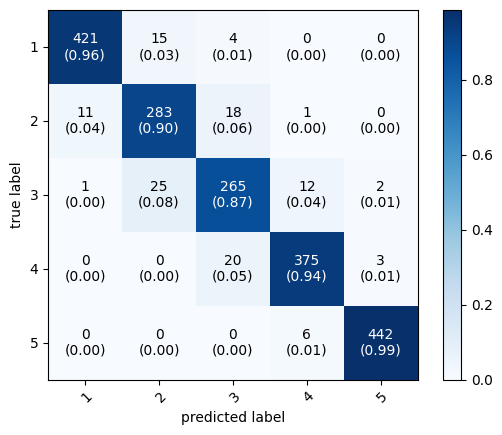

In [39]:
import torch
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

cmat = ConfusionMatrix(task="multiclass", num_classes = 5)
confusion_matrix = cmat(y_pred, y_true)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
                                class_names=[1, 2, 3, 4, 5],
                                show_normed=True,
                                colorbar=True)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()